# Overview

1. Test the tools to download, munge, model and compare various methods to forecast crop yields.
1. Flexibility in terms of the years, states, methods and crops used. 

# Goal

1. Our goal is to build a basic soybean yield model to predict the coming year's yield of that crop.  We will use features such as temperature (avg) and precipitation, US state, NDVI (measure of quality), podcount and test a shift operator to test the hypothesis that technolical change in the last few years has significantly, on linearly, increased yields

1. Yearly yields:
    
    <font size="3"> $$ Yields_{y} \sim Year + PodCount_{m} + State_{y} + Temp_{m} + Precip_{m} + Quality_{m} + Droughts_{m} + Shift + error_{y} $$ </font>
    

# Long-term Goals:
1. Automate process of modeling yield forecasts and other analyses.
2. Incorporate global data.
3. Provide a range of forecasts for comparison.

# Immediate Goals:
1. Use US data to forecast soybean yields.
2. Automate downloading of data and model scoring.
3. Provide figures.
4. Test and compare several forecasting methods.

# <u>Features</u>

## Yields (What we want to explain)

### Hypothsis: Historical yields are a good indicator of future yields.

1. Plots clearly show a significant trend.
2. Nonlinear (quadratic) term picks up rate of increase.
3. Look at all major soybean producing states.
4. Not accounting for irrigated vs not irrigated, data not good enough.

## Pod Count

### Hypothesis: A good intermediate pod count indicates a good final yield.

1. We aren't interested in the final pod count, rather the intermediate counts as a way to predict the final yields (which is highly related to the count).
2. So we need the pod counts for several intermediate months.
3. Available on a monthly basis, starting late in the year (Sep?).



## Weather Features

1. Min
2. Max
3. Precip

### These are our main features besides Year.

1. Bad weather in particular months will damage the soybean crops.  
2. Try to identify patterns in extreme events.
3. Polynomials and interactions.

## Quality of Crop
1. This is another feature examining the quality of a crop at a particular moment.
2. Available on a semi-weekly basis. 
3. Not many years available and rather spotty.  John suggested that the quality of these measures isn't good, are there other measures?



## Drought Measures
1. PDSI
2. PHDI
3. PM
4. PZ


### Lasso and Ridge regression

1. Let the model choose the most important features.
2. Play with the hyperparameters.

## Things to try

1. Ran initial models to get a feel for the data.
2. Tried simple models based on weather variables.
3. Add quality features.
4. Add irrigated vs non-irrigated.
5. Added drought features.
6. VIF to eliminate multi-collinearity.
3. Try all data, use Lasso, Ridge.

# <u>Modeling Process</u>

1. Notebooks to download each feature and put the data into a "model ready" state.
    Presentation_01/features
        a. NASS yield and acre data
        b. NASS quality measure
        c. NASS pod count
        d. NOAA precip, max, min temp
        e. NOAA drought measure
    Munged data sent to another file
2. A notebook to combine features (joinFeatures.ipynb).
    Presentation_01/joinFeatures.ipynb
3. A notebook to perform model selection, e.g. ridge and lasso regressions (featureSelection.iypnb).
    Presentation_01/featureSelection.ipynb
4. This notebook, which loops over various years and states, performs regressions, and summarize and compares outputs.
    Presentation_0b1/Project_MainFile.ipynb
5. A helper_Functions.ipynb to hold functions that will otherwise obscure more relevant code. 
    Presentation_01/helper_Functions.ipynb

# <u>Models</u>

### Imports and general settings

In [11]:
import ipynb
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
from ipynb.fs.full.joinFeatures import mergedData
from ipynb.fs.full.helper_Functions import descriptions1, mse1, mae1, myLasso
from functools import reduce

#Scikit learn
from sklearn.feature_selection import VarianceThreshold
#from sklearn.svm import LinearSV
from sklearn import linear_model 
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import PolynomialFeatures


### Import merged data, combine based on year key.

In [33]:
def mergedData():

    dataDir = '../USDA_NOAA_data/data_model_ready'
    entries = os.listdir('data_model_ready/')
    entries = [x for x in entries if not x.startswith(".ipynb")]

    allData = []
    for entry in entries:
        print(entry)
        dt1 = pd.read_csv(dataDir + "/" + entry)
        dt1.set_index('Year', inplace=True, drop=True)
        allData.append(dt1)
        #print(dt1.head())


    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Year', 'State'], how='outer'), allData)
    df_merged["Year"] = df_merged.index
    
    return(df_merged)

In [34]:
allData1 = mergedData()

model_allStates_pmdi1.csv
model_allStates_minTemp1.csv
model_allStates_precip.csv
model_allStates_quality.csv
model_allStates_zndx1.csv
model_allStates_pdsi1.csv
model_allStates_podcount.csv
model_allStates_yields.csv
model_allStates_maxTemp1.csv


In [35]:
allData1[allData1["State"] == "IOWA"]

,State,Pmdi1_May,Pmdi1_Jun,Pmdi1_Jul,Pmdi1_Aug,Pmdi1_Sep,Pmdi1_Oct,Mintemp_May,Mintemp_Jun,Mintemp_Jul,...,Oct_pod_forecast,Nov_pod_forecast,Yield,Maxtemp_May,Maxtemp_Jun,Maxtemp_Jul,Maxtemp_Aug,Maxtemp_Sep,Maxtemp_Oct,Year
Year,,,,,,,,,,,,,,,,,,,,,
1895,IOWA,-1.10,-1.14,-1.09,-0.26,-0.93,-1.45,48.0,56.6,58.1,...,NaN,NaN,NaN,73.9,81.9,85.1,84.9,79.4,58.6,1895
1896,IOWA,1.47,-0.15,1.98,1.78,2.17,2.77,53.8,57.0,60.2,...,NaN,NaN,NaN,76.6,82.0,84.4,82.7,68.5,59.4,1896
1897,IOWA,1.72,0.94,0.00,-1.53,-2.59,-3.30,44.6,56.5,62.9,...,NaN,NaN,NaN,71.1,79.9,87.2,80.3,84.3,68.6,1897
1898,IOWA,-2.03,-2.03,-2.45,-2.44,-2.67,-0.88,48.0,60.1,59.8,...,NaN,NaN,NaN,70.0,81.5,85.9,83.5,77.0,56.2,1898
1899,IOWA,0.93,1.04,0.46,-0.21,-1.15,-1.53,48.1,59.0,60.2,...,NaN,NaN,NaN,71.1,81.3,84.7,85.4,75.1,69.0,1899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,IOWA,3.79,2.15,3.50,4.18,4.89,4.36,48.1,61.2,63.1,...,1801.0,1861.0,60.0,70.9,84.8,82.6,81.9,77.8,66.3,2016
2017,IOWA,3.64,2.06,0.89,0.76,-0.86,1.28,47.2,58.6,63.6,...,1670.0,1717.0,57.0,69.8,83.6,85.8,78.8,79.1,63.4,2017
2018,IOWA,-0.04,1.23,0.98,2.48,4.14,5.14,55.3,63.1,62.4,...,1984.0,2082.0,56.0,78.7,83.1,83.8,82.3,75.9,58.3,2018


### Add dummy variable

In [36]:
allData1["YearDummy2005"] = 0
allData1.loc[allData1.Year > 2005, 'YearDummy2005'] = 1

allData1["YearDummy1980"] = 0
allData1.loc[allData1.Year > 1980, 'YearDummy1980'] = 1

allData1["YearDummy2013"] = 0
allData1.loc[allData1.Year > 2013, 'YearDummy2013'] = 1

### Which states and years to train and test

In [37]:
testYear  = 2015 #build model on years before this year, this is the training set
startYear = 1800 #grab all years
finalYear = 2021

#statesofInterest = ['IOWA', 'INDIANA', 'ILLINOIS', 'KANSAS', 'MINNESOTA', 'MISSOURI', 'NEBRASKA', 'NORTH DAKOTA', 'SOUTH DAKOTA', 'OHIO']
#statesofInterest = ['IOWA', 'INDIANA', 'ILLINOIS', 'MINNESOTA', 'OHIO']
statesofInterest = ['IOWA']

### Start loops over model per state

state:  IOWA
AutoLasso
                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     128.4
Date:                Thu, 01 Oct 2020   Prob (F-statistic):           3.18e-47
Time:                        17:44:24   Log-Likelihood:                -201.36
No. Observations:                  91   AIC:                             436.7
Df Residuals:                      74   BIC:                             479.4
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

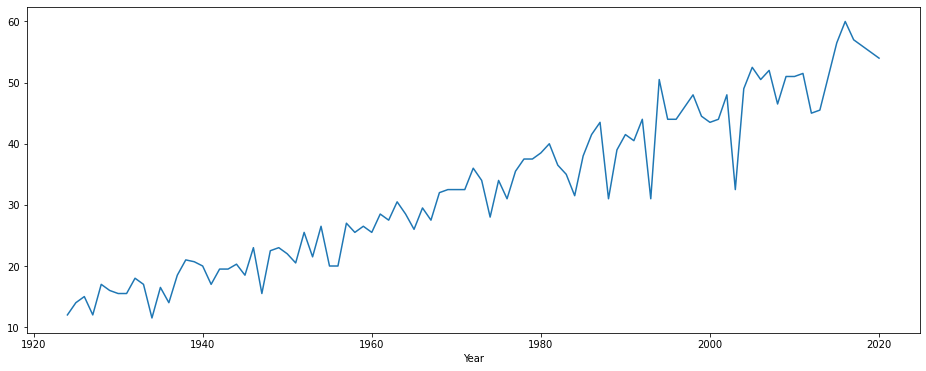

In [52]:
stateResults = []
verbose1 = False
for index1, state1 in enumerate(statesofInterest):
    myGuesses = []
    
    if verbose1 == False:
        # print("index: ", index1)
        print("state: ", state1)
    
    stData = allData1[allData1["State"] == state1]
    trainData = stData[stData["Year"] < testYear]
    testData = stData[stData["Year"]  >= testYear]
    
    if verbose1 == True:
         print("train: ", trainData.shape)
         print("train: ", testData.shape)    
    
    ########## Real ##########
    myGuesses.append(pd.DataFrame({"Observed": testData["Yield"]}))
    
    ########## Year Only ##########
    model = smf.ols('Yield ~ Year', data=trainData).fit()
    predictions =  model.predict(testData) # predict out of sample()
    
    myGuesses.append(pd.DataFrame({"year_only" : predictions}))
    
    if verbose1 == True:
        descriptions1("year_only", model, predictions)
    
    
    ########## Year + Year² ##########
    model = smf.ols('Yield ~ Year + I(Year**2) + YearDummy2013', data=trainData).fit()
    predictions =  model.predict(testData) # predict out of sample
    
    myGuesses.append(pd.DataFrame({"year__sq" : predictions}))
    
    if verbose1 == True:
        descriptions1("year_sq", model, predictions)
        
    ########## Max Temps ##########
    model = smf.ols('Yield ~ Year + I(Year**2) + Maxtemp_Jun + Maxtemp_Jul + Maxtemp_Aug', data=trainData).fit()
    predictions =  model.predict(testData) # predict out of sample
    
    myGuesses.append(pd.DataFrame({"maxTemps" : predictions}))
    
    if verbose1 == True:
        descriptions1("maxTemp", model, predictions)       
        
        
    ########## Precip ##########
    model = smf.ols('Yield ~ Year + I(Year**2) + Precip_Jun + Precip_Jul + Precip_Aug', data=trainData).fit()
    predictions =  model.predict(testData) # predict out of sample
    
    myGuesses.append(pd.DataFrame({"precip" : predictions}))
    
    if verbose1 == True:
        descriptions1("Precip", model, predictions)  
        
        
    ########## Precip + maxTemp ##########
    model = smf.ols('Yield ~ Year + I(Year**2) + Precip_Jul + Precip_Aug + Maxtemp_Jul + Maxtemp_Aug', data=trainData).fit()
    predictions =  model.predict(testData) # predict out of sample
    
    myGuesses.append(pd.DataFrame({"precip_temp" : predictions}))
    
    if verbose1 == True:
        descriptions1("Precip_Temp", model, predictions)    
        
        
    ########## Precip + maxTemp + comb ##########
    model = smf.ols('Yield ~ Year + I(Year**2) + Precip_Jul + Precip_Aug + Maxtemp_Jul + Maxtemp_Aug + I(Precip_Aug**2) + I(Precip_Jul*Precip_Aug)', data=trainData).fit()
    predictions =  model.predict(testData) # predict out of sample
    
    myGuesses.append(pd.DataFrame({"precip_temp_comb" : predictions}))
    
    if verbose1 == True:
        descriptions1("Precip_Temp_Comb", model, predictions)            
                       
    ########## Lasso ##############################        
    model = smf.ols('Yield ~ YearDummy2013 + Year  + I(Year**2) + I(Maxtemp_Aug**2) + I(Precip_Jun**3) + I(Precip_Jun*Precip_Jul**2) + I(Precip_Jun*Maxtemp_Jun**2) + \
    I(Precip_Jul**3) + I(Precip_Jul**2 * Precip_Aug) + I(Precip_Jul*Precip_Aug**2) + I(Precip_Jul*Maxtemp_Jun**2)+I(Precip_Aug*Maxtemp_Aug**2)' , data=trainData).fit()
    predictions =  model.predict(testData) # predict out of sample
    
    myGuesses.append(pd.DataFrame({"Lasso" : predictions}))
    
    if verbose1 == True:
        descriptions1("Lasso", model, predictions)  
                
        
    ########## Lasso2 ##############################        
    model = smf.ols('Yield ~ YearDummy2013 + Year + I(Year**2) + I(Year*Pmdi1_Aug) + I(Year*Mintemp_Aug) + \
                     I(Year*Precip_May) + I(Year*Precip_Aug) + I(Year*Maxtemp_Jun) + I(Year*Maxtemp_Aug)' , data=trainData).fit()
    predictions =  model.predict(testData) # predict out of sample
    
    myGuesses.append(pd.DataFrame({"Lasso2" : predictions}))
    
    if verbose1 == True:
        descriptions1("Lasso2", model, predictions)     
    
    
    ########## ARIMA ##########    
    # ARIMA
    series = trainData["Yield"] 
    trainData["Precip_Aug_sq"] = trainData["Precip_Aug"] * trainData["Precip_Aug"] 
    trainData["Year_sq"] = trainData["Year"] * trainData["Year"] 
    
    
    testData["Precip_Aug_sq"] = testData["Precip_Aug"] * testData["Precip_Aug"] 
    testData["Year_sq"] = testData["Year"] * testData["Year"] 
    
    myExog = trainData[["Precip_Aug", "Maxtemp_Aug"]]
    exog_forecast = testData[["Precip_Aug", "Maxtemp_Aug"]]
    
    order1 = sm.tsa.SARIMAX(series, exog=myExog, order=(3, 1, 0), trend='t')
    model = order1.fit()

    predictions = model.forecast(finalYear - testYear, exog=exog_forecast, dynamic= True)
    df1 = pd.DataFrame({"arima" : predictions})
    df1["Year"] = list(range(testYear, 2021))
    df1.set_index("Year", drop = True, inplace=True)
    
    myGuesses.append(df1)
    
    if verbose1 == True:
        descriptions1("ARIMA", model, predictions)    
    
    
    ########## Lasso ##########    
    # Lasso
    mat1 = ["Yield", "Year", "YearDummy2013", "Precip_Aug", "Maxtemp_Aug",  "Maxtemp_Jun", "Precip_Jun", "Maxtemp_Jul", "Precip_Jul"]
    
    matrices = {
        "IOWA":      ["Yield", "Year", "Maxtemp_Jun", "Maxtemp_Jul", "Maxtemp_Aug", "Precip_Jun","Precip_Jul", "Precip_Aug"],
        "INDIANA":   ["Yield", "Year", "YearDummy2013", "Maxtemp_Jun", "Maxtemp_Jul", "Maxtemp_Aug", "Precip_Jun","Precip_Jul", "Precip_Aug"],
        "ILLINOIS":  ["Yield", "Year", "YearDummy2013", "Maxtemp_Jun", "Maxtemp_Jul", "Maxtemp_Aug", "Precip_Jun","Precip_Jul", "Precip_Aug"],
        "MINNESOTA": ["Yield", "Year", "Maxtemp_Jun", "Maxtemp_Jul", "Maxtemp_Aug", "Precip_Jun","Precip_Jul", "Precip_Aug"],
        "OHIO":      ["Yield", "Year", "Precip_Jul", "Precip_Aug"]
    }

    alphas1 = {
      "IOWA":      5000,
      "INDIANA":   1500,
      "ILLINOIS":  2000,
      "MINNESOTA": 3000,
      "OHIO":      300  
    }
    
    myMinValues = {
      "IOWA":      1e-7,
      "INDIANA":   1e-7,
      "ILLINOIS":  1e-7,
      "MINNESOTA": 1e-7,
      "OHIO":      1e-7  
    }
    
    model, predictions = myLasso(trainData, testData, matrices[state1], alphas1[state1], myMinValues[state1])
    
    df1 = pd.DataFrame({"AutoLasso" : predictions})
    df1["Year"] = list(range(testYear, 2021))
    df1.set_index("Year", drop = True, inplace=True)
    
    myGuesses.append(df1)
    
    if verbose1 == False:
        descriptions1("AutoLasso", model, predictions)
    
    
    ####Print yield
    stData["Yield"].plot(figsize=(16,6))
    
    
    #####Combine
    stateResults.append(pd.concat(myGuesses, axis=1))
    

### Compare models for each state using MAE and MSE
1. There are other measures which can be used to assess model performance.
2. The basic idea for all measures is the same, how does the model forecast per year compare to the real value in the same year.
3. Allows us to compare model performance.

In [53]:
myResults = []
for index2, j in enumerate(stateResults):

    df1 = j
    print(statesofInterest[index2])
    
    ans1 = []
    for i in df1.columns:
        ans1.append(mse1(df1["Observed"], df1[i]))
    df1.loc["Mse"] = ans1
    
    ans1 = []
    for i in df1.columns:
        ans1.append(mae1(df1["Observed"], df1[i]))   
    df1.loc["Mae"] = ans1

    df1['State'] = statesofInterest[index2]
    pd.set_option('precision', 1)

    myResults.append(df1)

IOWA


### Forecasts
1. Year column, these are the years we are forecasting based on model built in previous years.
2. State column, all states a forecasted individually.
3. Observed column is the real or realized value.
4. All other columns are models.

In [54]:
for i in myResults:
     display(i)

,Observed,year_only,year__sq,maxTemps,precip,precip_temp,precip_temp_comb,Lasso,Lasso2,arima,AutoLasso,State
Year,,,,,,,,,,,,
2015,56.5,51.1,51.5,53.2,52.8,53.4,54.0,51.0,49.0,51.7,52.7,IOWA
2016,60.0,51.5,52.0,53.1,54.1,53.2,53.2,52.4,50.9,50.5,55.9,IOWA
2017,57.0,52.0,52.5,54.9,52.9,54.1,54.6,50.6,49.7,51.6,56.8,IOWA
2018,56.0,52.4,53.0,53.8,54.5,54.3,55.7,54.1,49.9,52.3,56.1,IOWA
2019,55.0,52.8,53.5,54.9,53.7,54.6,55.2,51.1,49.6,52.4,53.9,IOWA
2020,54.0,53.3,54.0,54.0,52.7,52.5,50.9,48.6,48.3,50.3,51.4,IOWA
Mse,0.0,144.7,121.1,67.0,71.2,69.9,67.7,178.1,291.3,177.3,38.9,IOWA
Mae,0.0,170.2,143.2,81.6,89.0,86.3,82.9,208.9,332.4,207.0,50.8,IOWA
